In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

## Tasks
We define the following quantities:
 * $P_\infty$ the probability that a node belongs to the giant component. This is the size of the largest component divided by the number of nodes
 * $S$ the average size of the components without the largest one

Start from the following networks:
 * ER, with $\langle k \rangle = 2$, $N=1000$
 * BE, with $m=2$, $N=1000$
 * the euflight data

Choose at least 4 different centrality measures (degree and betweennes should be included) measure and plot $P_\infty$ and $S$ as fucntion of the fraction of nodes removed. Remove nodes by ascending and descending centrality order. 


In [2]:
import networkx as nx
# Parameters
N = 1000  # Number of nodes
k_avg = 2  # Average degree
p = k_avg / (N - 1)  # Connection probability

# Create ER network
G = nx.erdos_renyi_graph(N, p)

# Verify the average degree
actual_avg_degree = sum(dict(G.degree()).values()) / N
print(f"Target average degree: {k_avg}")
print(f"Actual average degree: {actual_avg_degree:.3f}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Target average degree: 2
Actual average degree: 2.044
Number of nodes: 1000
Number of edges: 1022


In [3]:
# 1. DEGREE CENTRALITY
# Measures: Number of connections each node has
degree_centrality = nx.degree_centrality(G)

# 2. BETWEENNESS CENTRALITY  
# Measures: How often a node lies on shortest paths between other nodes
betweenness_centrality = nx.betweenness_centrality(G)

# 3. CLOSENESS CENTRALITY
# Measures: How close a node is to all other nodes (inverse of average distance)
closeness_centrality = nx.closeness_centrality(G)

# 4. EIGENVECTOR CENTRALITY
# Measures: Importance based on connections to other important nodes
katz_centrality = nx.katz_centrality(G)


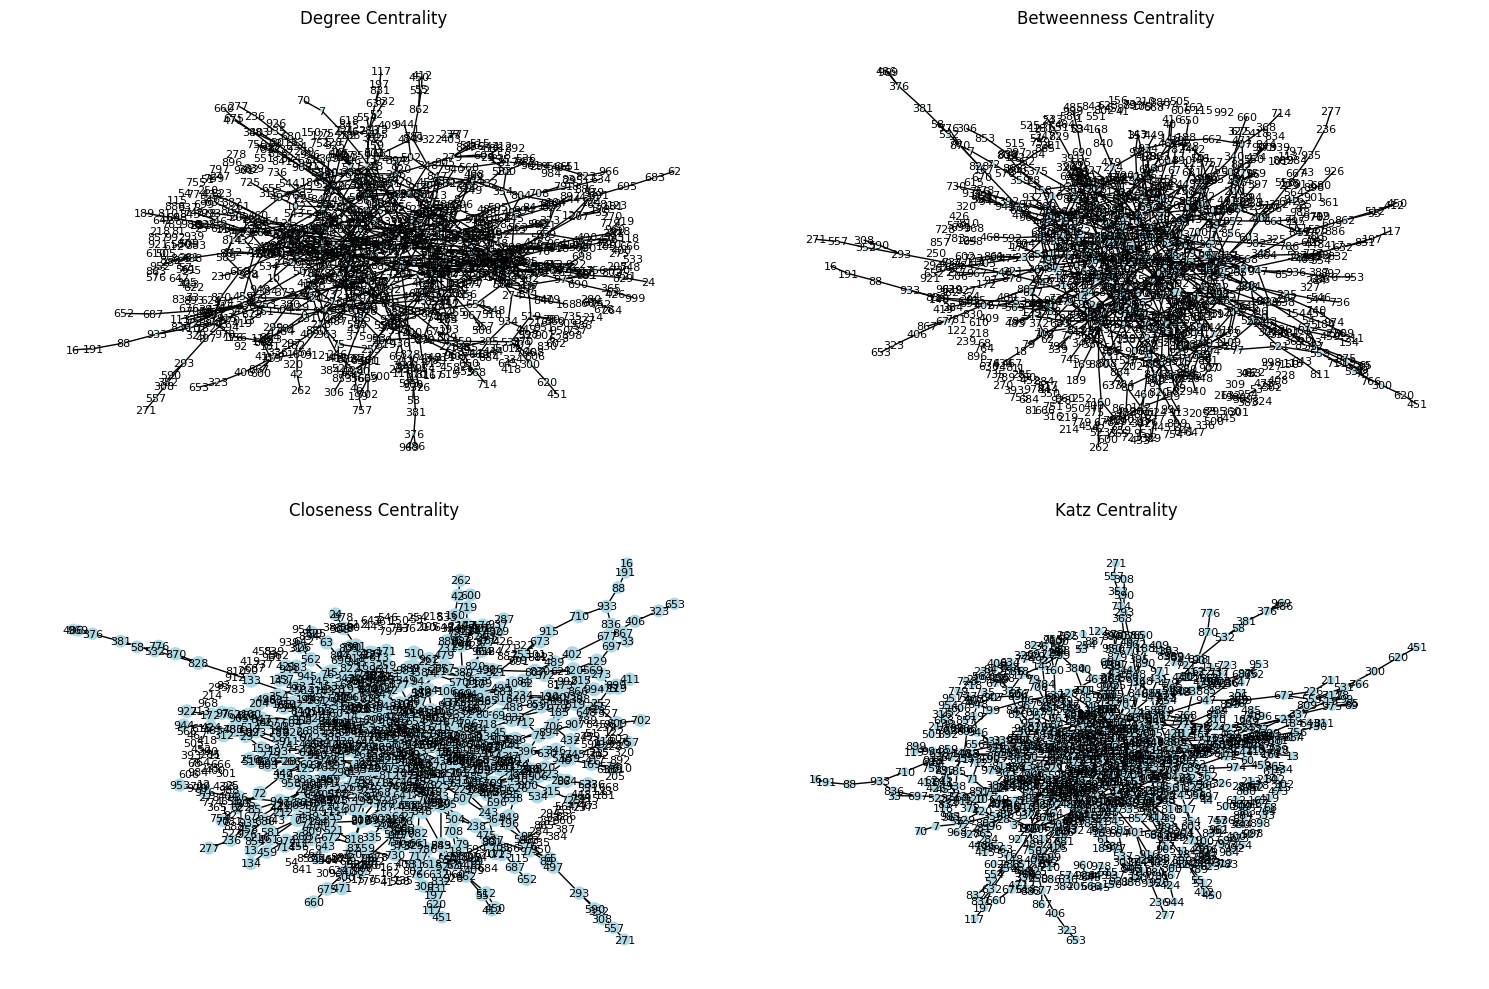

In [4]:
# Visualize the network with node sizes proportional to centrality
plt.figure(figsize=(15, 10))

centralities = [
    (degree_centrality, "Degree Centrality"),
    (betweenness_centrality, "Betweenness Centrality"), 
    (closeness_centrality, "Closeness Centrality"),
    (katz_centrality, "Katz Centrality")
]

for i, (centrality_dict, title) in enumerate(centralities, 1):
    plt.subplot(2, 2, i)
    pos = nx.spring_layout(G)
    
    # Node sizes proportional to centrality
    node_sizes = [centrality_dict[node] * 1000 for node in G.nodes()]
    
    nx.draw(G, pos, 
            node_size=node_sizes,
            node_color='lightblue',
            with_labels=True,
            font_size=8)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def calculate_P_infinity(G):
    """Calculate P∞ - size of largest component / total nodes"""
    if G.number_of_nodes() == 0:
        return 0
    
    # Find all connected components
    components = list(nx.connected_components(G))
    if not components:
        return 0
    
    # Size of largest component
    largest_component_size = max(len(comp) for comp in components)
    return largest_component_size / G.number_of_nodes()

def calculate_S(G):
    """Calculate S - average size of components excluding the largest one"""
    if G.number_of_nodes() == 0:
        return 0
    
    # Find all connected components
    components = list(nx.connected_components(G))
    if len(components) <= 1:
        return 0  # No components to average (or only one component)
    
    # Sort components by size
    component_sizes = sorted([len(comp) for comp in components], reverse=True)
    
    # Exclude the largest component and average the rest
    smaller_components = component_sizes[1:]
    return np.mean(smaller_components) if smaller_components else 0

def remove_nodes_by_centrality(G, centrality_dict, ascending=True):
    """
    Remove nodes based on centrality measure
    ascending=True: remove least central nodes first
    ascending=False: remove most central nodes first
    """
    # Sort nodes by centrality
    nodes_sorted = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=not ascending)
    
    # Extract just the node IDs
    removal_order = [node for node, centrality in nodes_sorted]
    
    # Track results
    fractions_removed = []
    P_infinity_values = []
    S_values = []
    
    # Create a copy to work with
    G_working = G.copy()
    
    # Remove nodes in steps (e.g., every 1% of nodes)
    step_size = max(1, N // 100)  # Remove 1% at a time
    
    for i in range(0, N, step_size):
        if i == 0:
            # Initial state (no nodes removed yet)
            fraction_removed = 0.0
        else:
            # Remove the next batch of nodes
            nodes_to_remove = removal_order[:i]
            G_working.remove_nodes_from(nodes_to_remove)
            fraction_removed = i / N
        
        # Calculate P∞ and S
        P_inf = calculate_P_infinity(G_working)
        S_avg = calculate_S(G_working)
        
        # Store results
        fractions_removed.append(fraction_removed)
        P_infinity_values.append(P_inf)
        S_values.append(S_avg)
        
        # Stop if network is completely disconnected
        if G_working.number_of_nodes() == 0:
            break
    
    return fractions_removed, P_infinity_values, S_values

In [6]:
# Remove nodes by degree centrality (ascending = least central first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, degree_centrality, ascending=True)

# Remove nodes by degree centrality (descending = most central first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, degree_centrality, ascending=False)

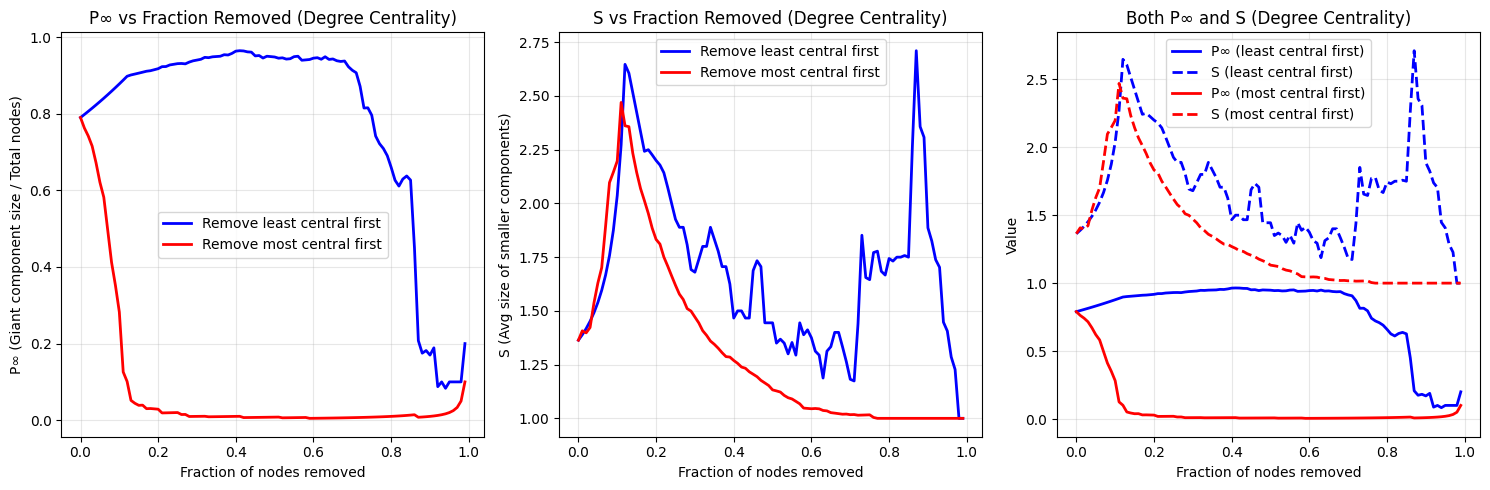

In [7]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least central first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most central first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Degree Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least central first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most central first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Degree Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least central first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least central first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most central first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most central first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Degree Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Remove nodes by betweeness centrality (ascending = least central first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, betweenness_centrality, ascending=True)

# Remove nodes by betweeness centrality (descending = most central first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, betweenness_centrality, ascending=False)

In [ ]:
for i, j in zip(fractions_asc, S_asc):
    print(i, j)



0.0 1.3636363636363635
0.01 1.34640522875817
0.02 1.3333333333333333
0.03 1.32
0.04 1.3108108108108107
0.05 1.289655172413793
0.06 1.2887323943661972
0.07 1.2877697841726619
0.08 1.2941176470588236
0.09 1.2923076923076924
0.1 1.3015873015873016
0.11 1.2845528455284554
0.12 1.2773109243697478
0.13 1.2869565217391303
0.14 1.2792792792792793
0.15 1.2710280373831775
0.16 1.2621359223300972
0.17 1.27
0.18 1.2604166666666667
0.19 1.25
0.2 1.2580645161290323
0.21 1.2555555555555555
0.22 1.2619047619047619
0.23 1.2317073170731707
0.24 1.2179487179487178
0.25 1.2266666666666666
0.26 1.2394366197183098
0.27 1.2615384615384615
0.28 1.2622950819672132
0.29 1.271186440677966
0.3 1.290909090909091
0.31 1.3
0.32 1.3333333333333333
0.33 1.3658536585365855
0.34 1.3783783783783783
0.35 1.3529411764705883
0.36 1.4285714285714286
0.37 1.4615384615384615
0.38 1.5
0.39 1.4736842105263157
0.4 1.5
0.41 2.2
0.42 1.0
0.43 0
0.44 0
0.45 0
0.46 0
0.47 0
0.48 0
0.49 0
0.5 0
0.51 0
0.52 0
0.53 0
0.54 0
0.55 0
0.56 

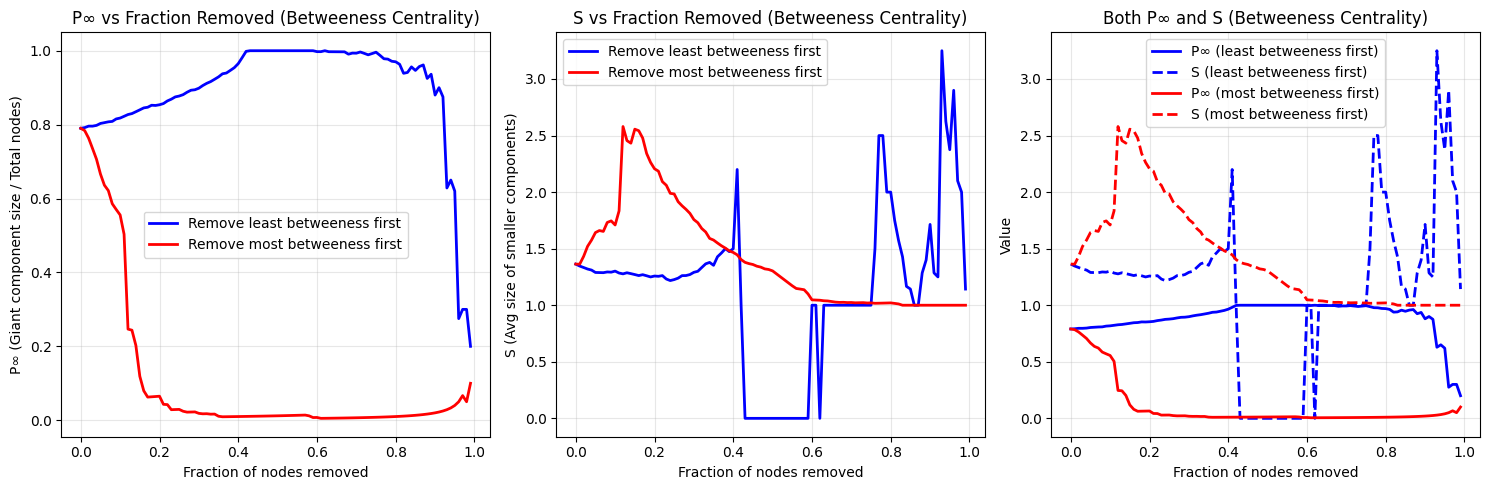

In [21]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least betweeness first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most betweeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Betweeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least betweeness first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most betweeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Betweeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least betweeness first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least betweeness first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most betweeness first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most betweeness first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Betweeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

There's some weird stuff happening to the average size of the smaller components - S calculates to 0 at certain points, then it jumps back to one. I have some theories as to why this may happen (excluding my code having an error - I don't think it does but I'm note sure).

In [24]:
# Remove nodes by closeness centrality (ascending = least close first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, closeness_centrality, ascending=True)

# Remove nodes by closeness centrality (descending = most close first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, closeness_centrality, ascending=False)

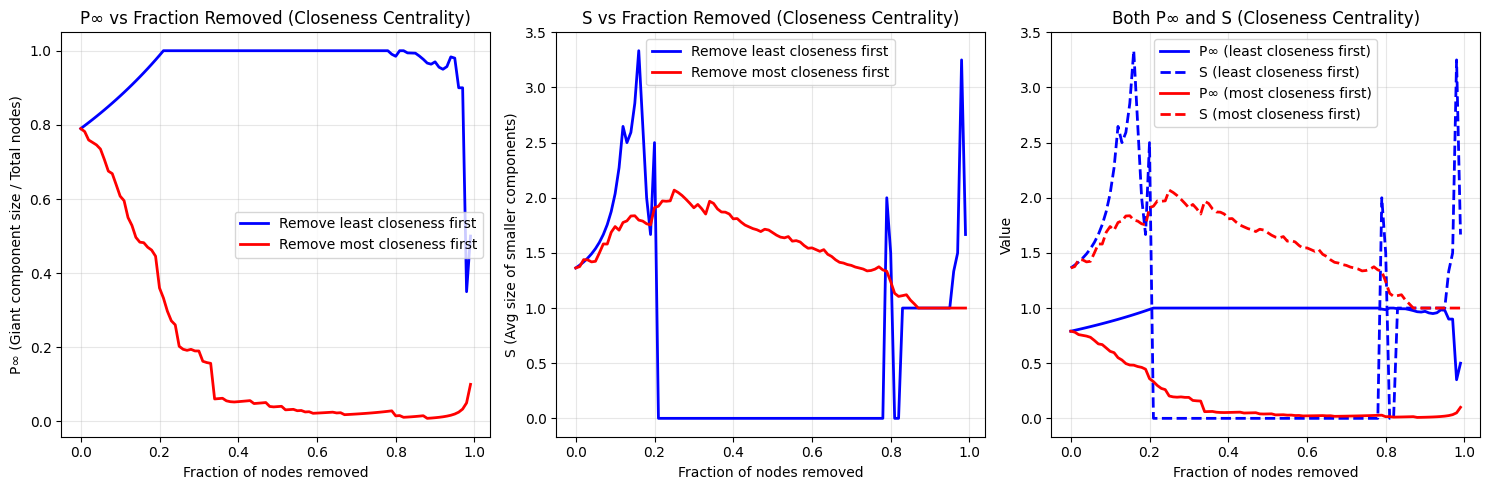

In [25]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least closeness first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most closeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Closeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least closeness first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most closeness first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Closeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least closeness first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least closeness first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most closeness first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most closeness first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Closeness Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

These strange graphs are confusing me... does the S value go to 0 when the graph turns into one completely connected piece

In [26]:
# Remove nodes by closeness centrality (ascending = least close first)
fractions_asc, P_inf_asc, S_asc = remove_nodes_by_centrality(G, katz_centrality, ascending=True)

# Remove nodes by closeness centrality (descending = most close first)  
fractions_desc, P_inf_desc, S_desc = remove_nodes_by_centrality(G, katz_centrality, ascending=False)

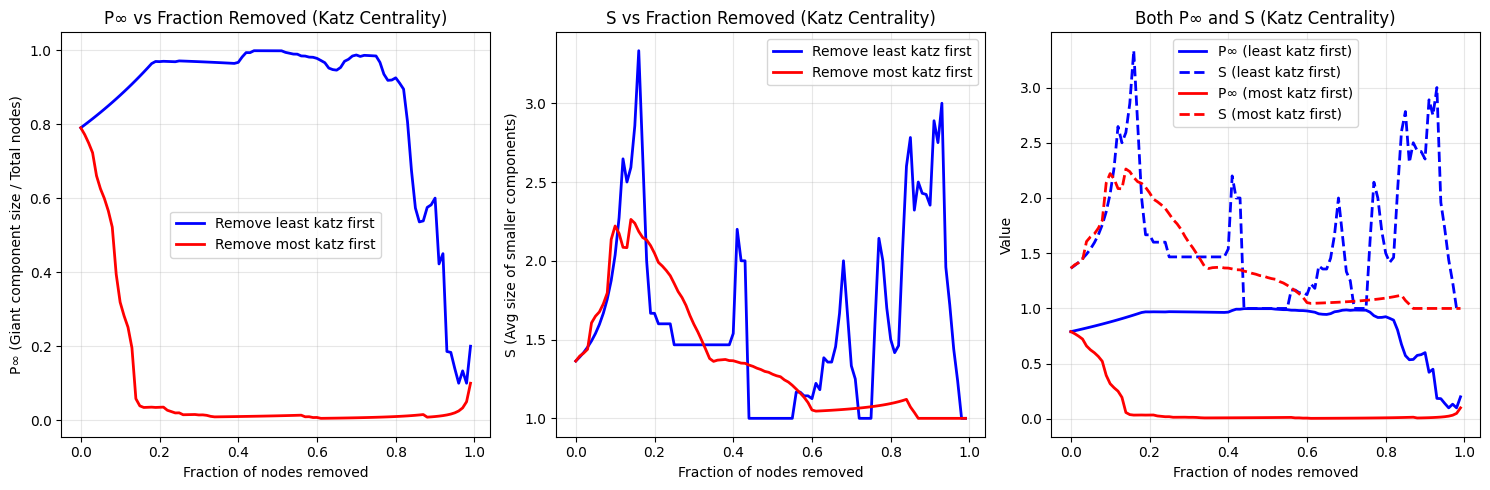

In [27]:
plt.figure(figsize=(15, 5))

# Plot P∞
plt.subplot(1, 3, 1)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='Remove least katz first', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='Remove most katz first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('P∞ (Giant component size / Total nodes)')
plt.title('P∞ vs Fraction Removed (Katz Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot S
plt.subplot(1, 3, 2)
plt.plot(fractions_asc, S_asc, 'b-', label='Remove least katz first', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r-', label='Remove most katz first', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('S (Avg size of smaller components)')
plt.title('S vs Fraction Removed (Katz Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot both together
plt.subplot(1, 3, 3)
plt.plot(fractions_asc, P_inf_asc, 'b-', label='P∞ (least katz first)', linewidth=2)
plt.plot(fractions_asc, S_asc, 'b--', label='S (least katz first)', linewidth=2)
plt.plot(fractions_desc, P_inf_desc, 'r-', label='P∞ (most katz first)', linewidth=2)
plt.plot(fractions_desc, S_desc, 'r--', label='S (most katz first)', linewidth=2)
plt.xlabel('Fraction of nodes removed')
plt.ylabel('Value')
plt.title('Both P∞ and S (Katz Centrality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()